# WandB and R&D Coding 

In [1]:
# Some imports

# computation stuff
import torch
import numpy as np

# plotting stuff
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina' # makes the quality higher

import seaborn as sns
sns.set_style("whitegrid") # improves the quality of matplotlib images and adds grid

# DNN Training pipeline (for reference)

Before we go to the main part, let's reuse code from previous time:

In [7]:
from torch.utils.data import DataLoader, Dataset

In [8]:
import torchvision
from torch import nn

In [9]:
transform = torchvision.transforms.Compose( # Sequential application of transforms, for this example it is unnecessarily
    [
        torchvision.transforms.ToTensor(), # from Image class to Tensor
    ]
)

In [10]:
mnist_train = torchvision.datasets.MNIST(
    "./mnist/", train=True, download=True, transform=transform
)
mnist_val = torchvision.datasets.MNIST(
    "./mnist/", train=False, download=True, transform=transform
)

torch.Size([1, 28, 28])


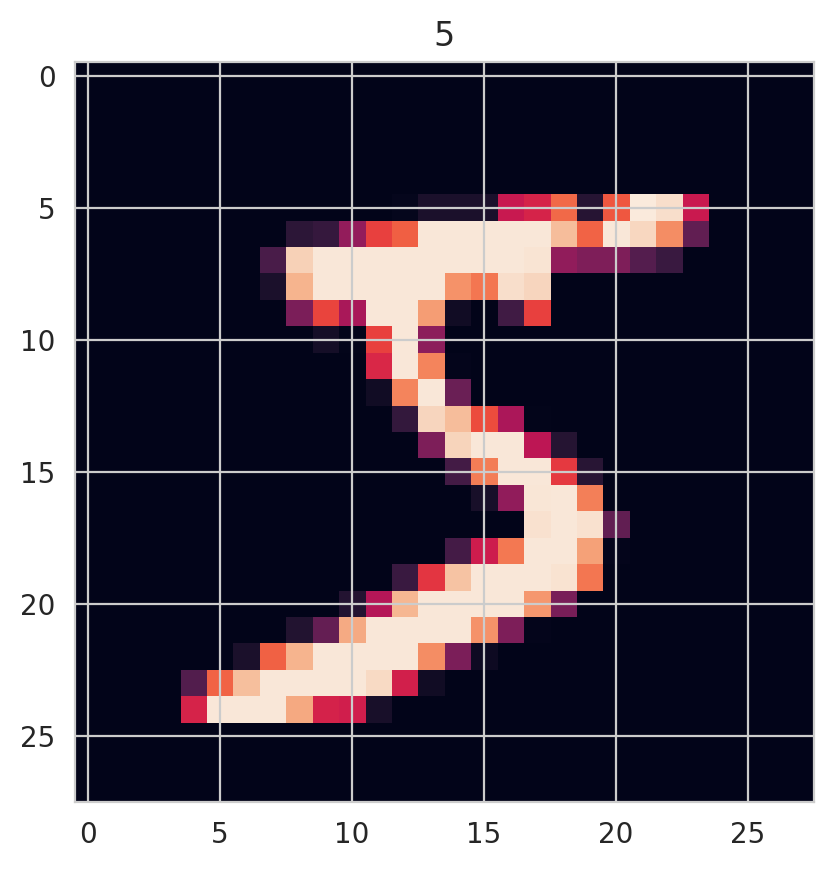

In [11]:
example_img, example_label = mnist_train[0]
print(example_img.shape) # C x H x W, 1 channel -- grayscale image
plt.imshow(example_img[0])
plt.title(example_label)
plt.show()

In [12]:
train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=128, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=128, shuffle=False)

In [13]:
class FCNetwork(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()      

        self.net = nn.Sequential(
            nn.Flatten(), # reshape input from C x H x W to 1D-vector
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, input_data):
        return self.net(input_data)

In [14]:
class ConvNetwork(nn.Module):
    
    def __init__(self, input_channels, hidden_channels, output_size, image_sizes):
        super().__init__()      

        self.net = nn.Sequential(
            nn.Conv2d(input_channels, hidden_channels, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(), # to do classification we flatten
            # you need to calculate the flatten size
            nn.Linear(hidden_channels * image_sizes[0] * image_sizes[1], output_size),
        )

    def forward(self, input_data):
        return self.net(input_data)

In [15]:
class ResBlock(nn.Module):

    def __init__(self, input_channels, hidden_channels):
        super().__init__()

        self.convs = nn.Sequential(
            nn.Conv2d(input_channels, hidden_channels, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(),
        )

        self.downsample = None
        if input_channels != hidden_channels:
            self.downsample_conv = nn.Conv2d(input_channels, hidden_channels, kernel_size=1)

    def forward(self, x):
        output = self.convs(x)
        if self.downsample is not None:
            # sometimes output + x won't work due to shape mismatch
            # for example if height and width does not match
            # or if channels does not match (if we have only single channel it will work though, but in general won't)
            x = self.downsample(x)
        return output + x # residual connection


class ResNetwork(nn.Module):
    
    def __init__(self, input_channels, hidden_channels, output_size, image_sizes):
        super().__init__()      

        self.net = nn.Sequential(
            ResBlock(input_channels, hidden_channels),
            ResBlock(hidden_channels, hidden_channels),
            nn.Flatten(), # to do classification we flatten
            # you need to calculate the flatten size
            nn.Linear(hidden_channels * image_sizes[0] * image_sizes[1], output_size),
        )

    def forward(self, input_data):
        return self.net(input_data)

In [16]:
fc_net = FCNetwork(example_img.flatten().shape[0], 128, 10) # 10 labels
print(fc_net)

FCNetwork(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [17]:
conv_net = ConvNetwork(1, 32, 10, image_sizes=example_img.shape[1:]) # 10 labels
print(conv_net)

ConvNetwork(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=25088, out_features=10, bias=True)
  )
)


In [18]:
res_net = ResNetwork(1, 32, 10, image_sizes=example_img.shape[1:]) # 10 labels
print(res_net)

ResNetwork(
  (net): Sequential(
    (0): ResBlock(
      (convs): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
      (downsample_conv): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): ResBlock(
      (convs): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=25088, out_features=10, bias=True)
  )
)


In [19]:
criterion = nn.CrossEntropyLoss()

### Training pipeline

In [20]:
from IPython import display

In [21]:
from tqdm.auto import tqdm

In [22]:
def train_one_epoch(model, dataloader, criterion, optimizer, scheduler, device):
    # some layers may have different behavior for train and inference
    # this is why it is important to set model to train mode during training
    model.train()

    avg_loss = 0
    for batch_idx, (image, label) in tqdm(enumerate(dataloader), total=len(dataloader)):
        # if we want to use GPU for model forward, we need to put inputs and desired outputs on device 
        image, label = image.to(device), label.to(device)

        output = model(image) # calculate model output
        loss = criterion(output, label) # calculate loss

        loss.backward() # calculate gradients
        optimizer.step() # update weights
        optimizer.zero_grad() # zero gradients for the next step
        scheduler.step() # update learning rate

        avg_loss += loss.item() # item to detach loss and get element on CPU
        # item is used for tensors containing single scalar

    # batch-idx + 1 == the total number of batches == len(dataloader)
    avg_loss = avg_loss / (batch_idx + 1)
    return avg_loss


def evaluate(model, dataloader, criterion, device):
    # some layers may have different behavior for train and inference
    # this is why it is important to set model to eval mode during inference
    model.eval()

    avg_loss = 0
    accuracy = 0
    total_elements = 0
    for batch_idx, (image, label) in enumerate(dataloader):
        # if we want to use GPU for model forward, we need to put inputs and desired outputs on device 
        image, label = image.to(device), label.to(device)

        output = model(image) # calculate model output
        loss = criterion(output, label) # calculate loss

        # you should also calculate some metrics, like accuracy
        accuracy += (output.argmax(-1) == label).sum().item()
        total_elements += output.shape[0] # we will use it to calculate accuracy
        avg_loss += loss.item()

    # batch-idx + 1 == the total number of batches == len(dataloader)
    avg_loss = avg_loss / (batch_idx + 1)
    accuracy = 100 * accuracy / total_elements
    return avg_loss, accuracy


def train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, device, n_epochs):

    train_avg_losses = []
    val_avg_losses = []
    val_accuracy_list = []
    for epoch in range(n_epochs):        
        train_avg_loss = train_one_epoch(model, train_dataloader, criterion, optimizer, scheduler, device)
        val_avg_loss, val_accuracy = evaluate(model, val_dataloader, criterion, device)

        # some logging
                
        # clear output so to redraw the plot
        display.clear_output(wait=True)

        train_avg_losses.append(train_avg_loss)
        val_avg_losses.append(val_avg_loss)
        val_accuracy_list.append(val_accuracy)

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        axes[0].plot(train_avg_losses, color="blue", label="train")
        axes[0].plot(val_avg_losses, color="red", label="val")
        axes[0].set_xlabel("Epoch number")
        axes[0].set_ylabel("Loss")
        axes[0].set_title(f"Min train loss: {round(min(train_avg_losses), 5)}, min val loss: {round(min(val_avg_losses), 5)}")

        axes[1].plot(val_accuracy_list, color="red", label="val")
        axes[1].set_xlabel("Epoch number")
        axes[1].set_ylabel("Accuracy (%)")
        axes[1].set_title(f"Best Accuracy (%): {max(val_accuracy_list)}")
        
        plt.legend()
        plt.tight_layout()
        plt.show()

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu" # "cuda" -- use GPU, "cpu" -- use CPU
print(device)

cuda


In [24]:
NUM_EPOCHS = 10

In [23]:
# FC net

# do not forget to put the model itself on device
fc_net = FCNetwork(example_img.flatten().shape[0], 128, 10) # 10 labels
fc_net.to(device)

# define optimizer and scheduler to update weights and learning rate, respectively
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS * len(train_dataloader), eta_min=1e-4)

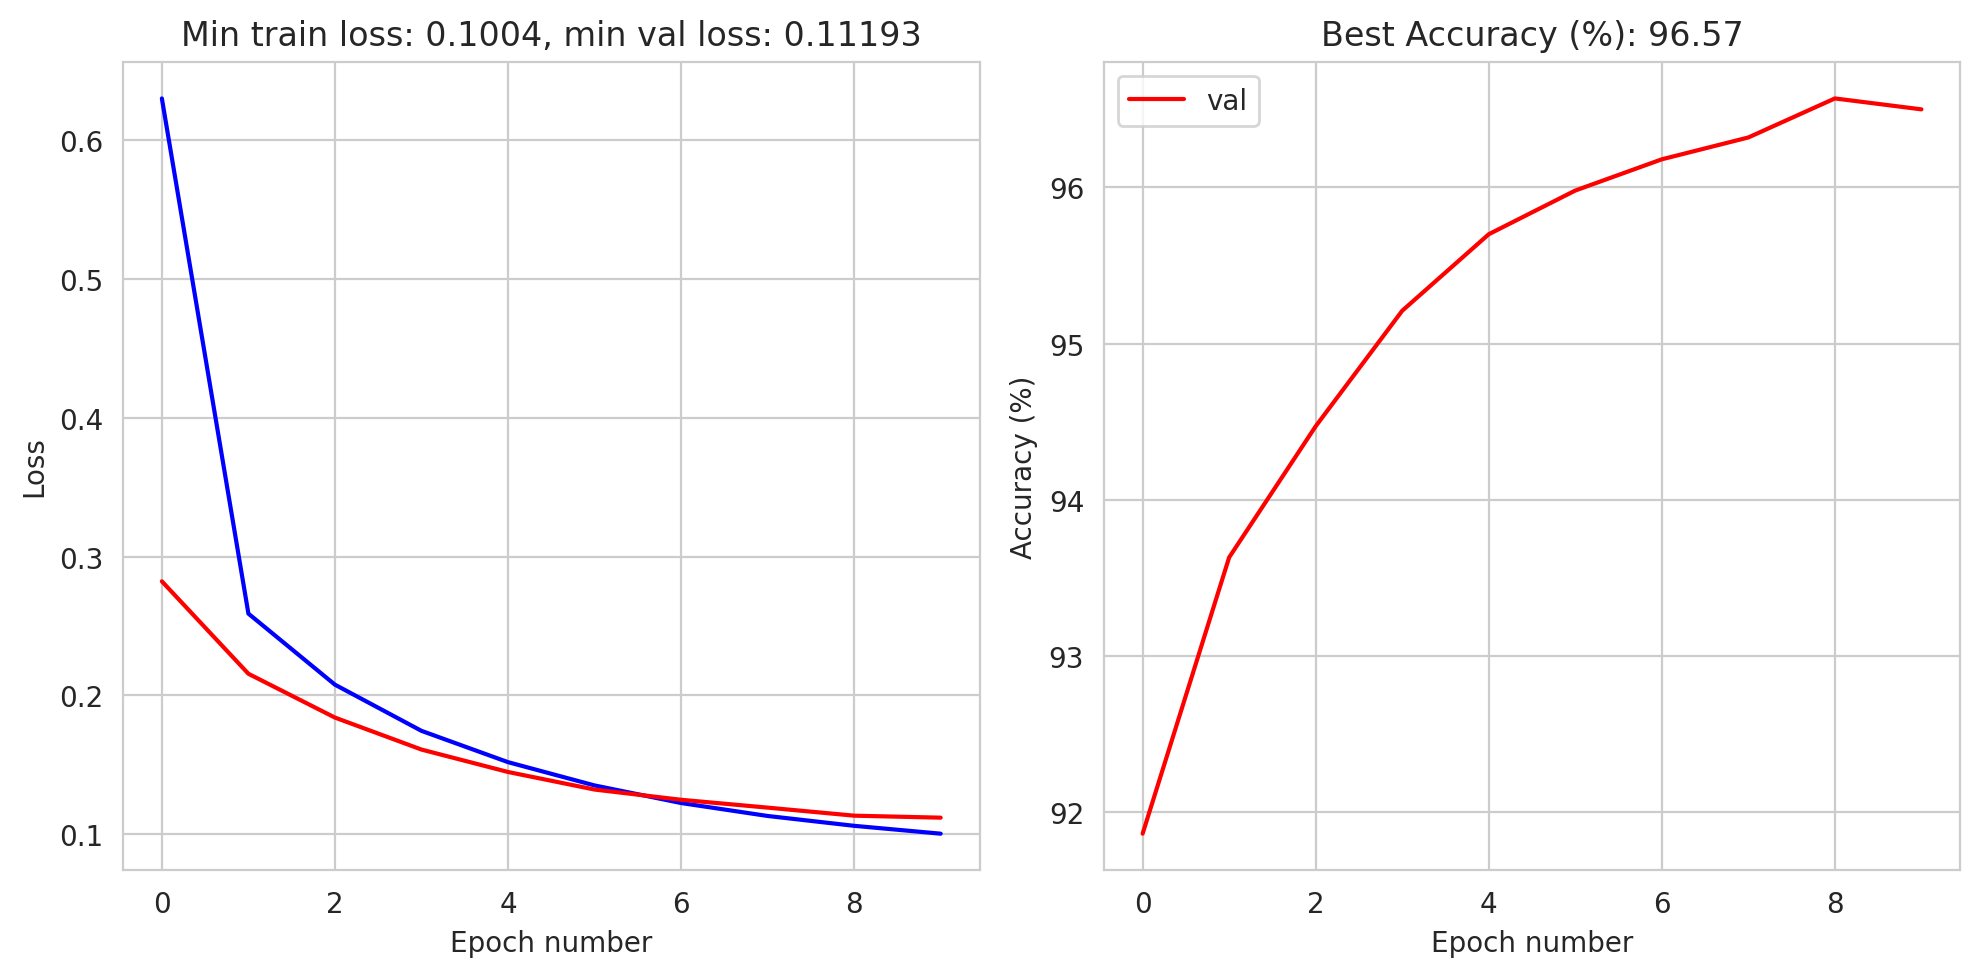

In [24]:
train(fc_net, train_dataloader, val_dataloader, criterion, optimizer, scheduler, device, NUM_EPOCHS)

In [25]:
# Conv net

# do not forget to put the model itself on device
conv_net = ConvNetwork(1, 32, 10, image_sizes=example_img.shape[1:]) # 10 labels
conv_net.to(device)

optimizer = torch.optim.Adam(conv_net.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS * len(train_dataloader), eta_min=1e-4)

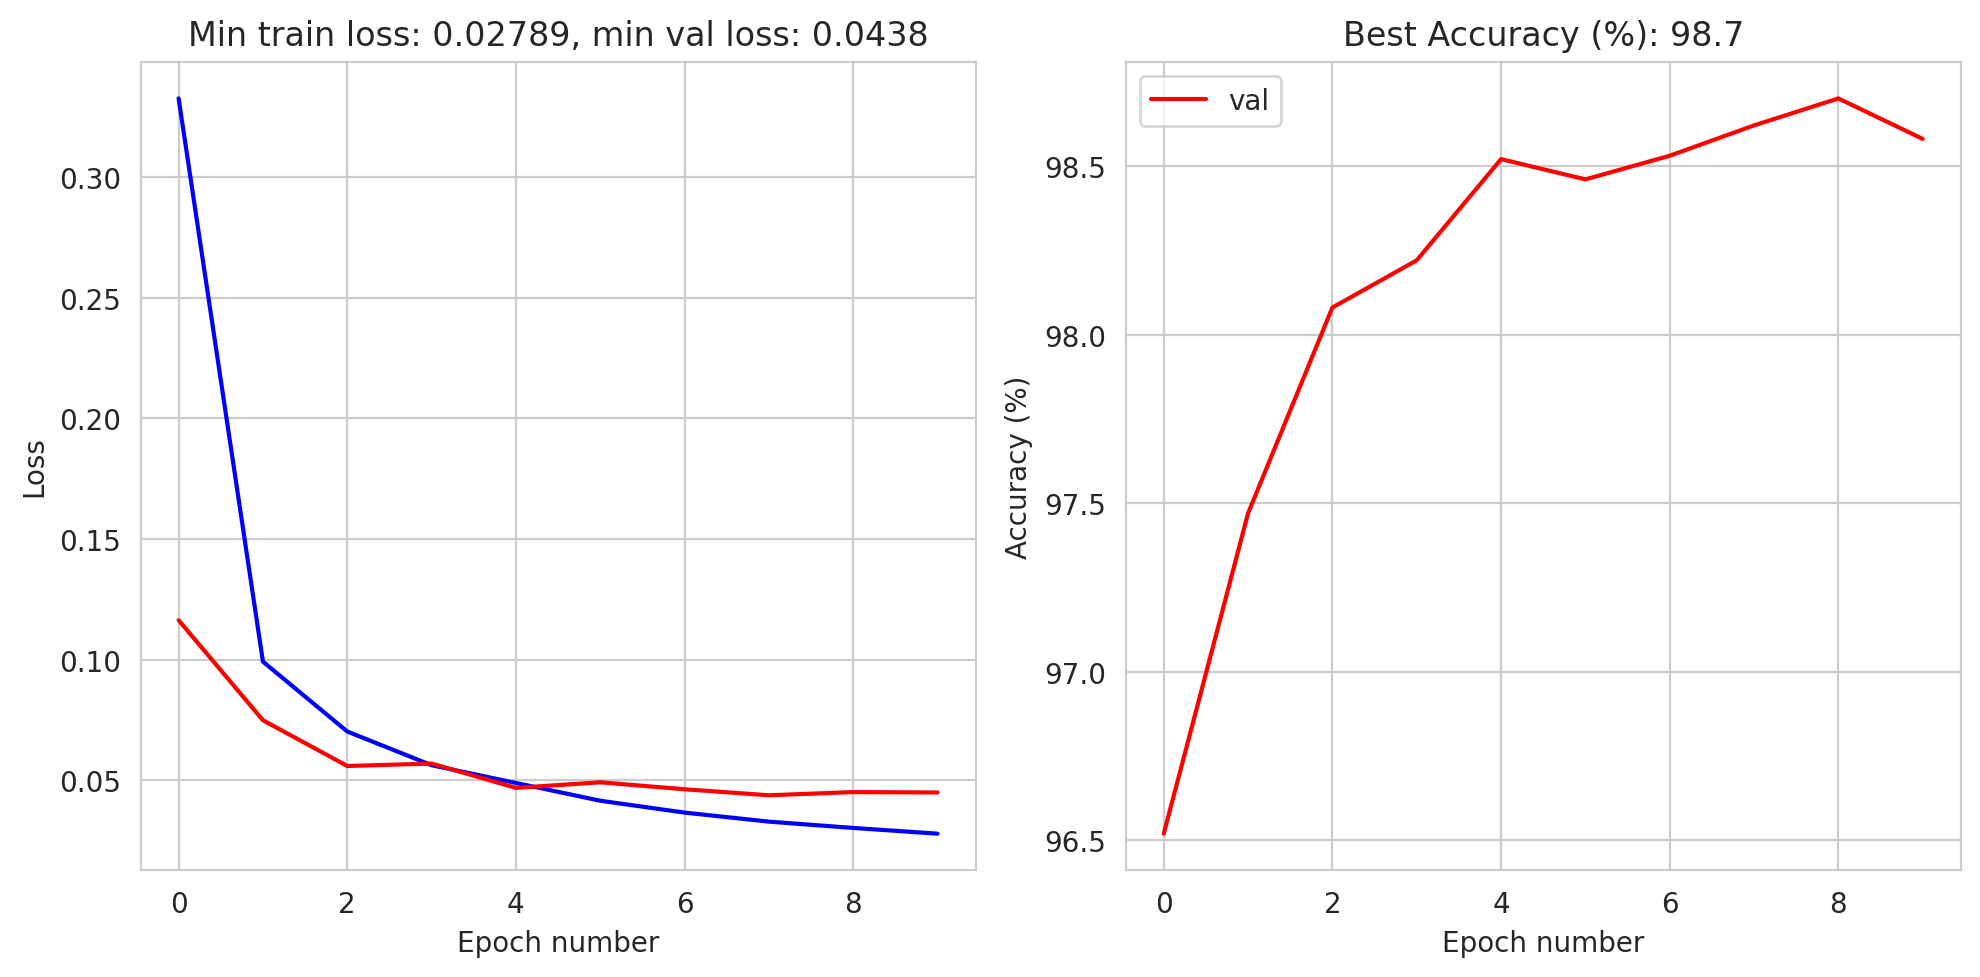

In [26]:
train(conv_net, train_dataloader, val_dataloader, criterion, optimizer, scheduler, device, NUM_EPOCHS)

# Logging (WandB and friends)

While training the model, it is useful to monitor several aspects:

1. What is the quality of our model? Does it overfit on training data? 
2. Should we stop the training or continue?
3. Does the model input looks reasonable or we corrupted it too severely?
4. What is the learning rate, is it too small or good enough?
5. etc.

All these stuff is required to effectively use the computational resources and properly design data processing pipeline and model training scheme. To do this, we should add logging.

Until now, we logged everything using hand-crafted calculations and plotting. This have several disadvantages:

1. A lot of extra code only for logging purposes. Plotting too much stuff might be hard
2. Simultaneously visualizing different types of data (audio and text, or text and images) together with all the plots is complicated
3. Comparing plots between models or different runs of the same model requires writing code to save logs and code to load these logs and visualize all the data again

**TL;DR:** While doing everything by yourself is possible, it is not efficient.

----

There exist several visualization tools. Here are some of them with **subjective** comments:

* [WandB](https://wandb.ai/site) -- easy to use and cool website to monitor logs from **different machines**
* [MLflow](https://mlflow.org/) -- easy to use but website is less intuitive and it is harder to compare logs from different machines
* [TensorBoard](https://www.tensorflow.org/tensorboard) -- rather old but still popular, might consume a lot of resources (from seminar author's experience). However, it contains unique cool features like **profiler support** (see [here](https://pytorch.org/tutorials/intermediate/tensorboard_profiler_tutorial.html))
* [aim](https://github.com/aimhubio/aim) -- seminar author have not try it, but it is **open-source** which is cool
* [ClearML](https://github.com/allegroai/clearml) -- seminar author have not try it, but it contains **tons of different features**

We will focus on **WandB** in this seminar, but the general usage API is similar within these tools. Let's rewrite our pipeline with WandB

In [4]:
# to begin with, you should create an account on WanbB website

import wandb

# this will ask your for your API key
wandb.login()

See how we deleted a lot of hand-crafted logging code and were able to log more stuff without problems in just a few lines:

In [25]:
def train_one_epoch(model, dataloader, criterion, optimizer, scheduler, device, epoch):
    # some layers may have different behavior for train and inference
    # this is why it is important to set model to train mode during training
    model.train()

    avg_loss = 0
    step = epoch * len(dataloader) # current step
    for batch_idx, (image, label) in tqdm(enumerate(dataloader), total=len(dataloader)):
        # if we want to use GPU for model forward, we need to put inputs and desired outputs on device 
        image, label = image.to(device), label.to(device)

        output = model(image) # calculate model output
        loss = criterion(output, label) # calculate loss

        loss.backward() # calculate gradients
        optimizer.step() # update weights
        optimizer.zero_grad() # zero gradients for the next step
        scheduler.step() # update learning rate

        avg_loss += loss.item() # item to detach loss and get element on CPU
        # item is used for tensors containing single scalar

        # the simplicity of wandb logging allows us to easily add more logging
        # and do not care about plotting functions too much
        wandb.log({
            "train_step_loss": loss.item(),
            "lr": scheduler.get_last_lr()[0] # get current lr for the 0th param group
        }, step=step + batch_idx)

        # we can also log images, for example
        if batch_idx == 0: # let's log only the first batch
            # sometimes you may need to use matplotlib wrapper around your image
            # to make sure it is visualized correctly
            # for example if your image tensor is in [-1, 1] and not [0, 1]. Be careful
            
            wandb.log({"train_image": wandb.Image(image[0])}, step=step+batch_idx)

    # batch-idx + 1 == the total number of batches == len(dataloader)
    avg_loss = avg_loss / (batch_idx + 1)
    return avg_loss


def evaluate(model, dataloader, criterion, device):
    # some layers may have different behavior for train and inference
    # this is why it is important to set model to eval mode during inference
    model.eval()

    avg_loss = 0
    accuracy = 0
    total_elements = 0
    for batch_idx, (image, label) in enumerate(dataloader):
        # if we want to use GPU for model forward, we need to put inputs and desired outputs on device 
        image, label = image.to(device), label.to(device)

        output = model(image) # calculate model output
        loss = criterion(output, label) # calculate loss

        # you should also calculate some metrics, like accuracy
        accuracy += (output.argmax(-1) == label).sum().item()
        total_elements += output.shape[0] # we will use it to calculate accuracy
        avg_loss += loss.item()

    # batch-idx + 1 == the total number of batches == len(dataloader)
    avg_loss = avg_loss / (batch_idx + 1)
    accuracy = 100 * accuracy / total_elements
    return avg_loss, accuracy


def train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, device, n_epochs):

    train_avg_losses = []
    val_avg_losses = []
    val_accuracy_list = []

    for epoch in range(n_epochs):        
        train_avg_loss = train_one_epoch(model, train_dataloader, criterion, optimizer, scheduler, device, epoch)
        val_avg_loss, val_accuracy = evaluate(model, val_dataloader, criterion, device)

        # some logging

        # No need to write plotting functions
        wandb.log({
            "train_avg_loss": train_avg_loss, # no need to create lists yourself
            "val_avg_loss": val_avg_loss,
            "val_accuracy": val_accuracy,
        }, step=(epoch + 1) * len(train_dataloader)) # this is the total number of steps until now
        
        # we provide step explicitly because otherwise each logging call will increase inner wandb step variable
        # this allows us to log to the same step from different parts of the code

Wrap your code in `wandb` contextual manager. This makes sure that `wandb` is closed after you pipeline is done or broken. Two arguments "project" and "name" are mandatory. We will show other arguments later

```python
with wandb.init(
                project="seminar_wandb_test", # project name
                name="test_run" # run name within the project
            ) as run:
    train(...) # start training pipeline
```

Let's see examples with FC and Conv nets from previous lesson.

In [26]:
# FC net

# do not forget to put the model itself on device
fc_net = FCNetwork(example_img.flatten().shape[0], 128, 10) # 10 labels
fc_net.to(device)

# define optimizer and scheduler to update weights and learning rate, respectively
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS * len(train_dataloader), eta_min=1e-4)

In [31]:
with wandb.init(
                project="seminar_wandb_test", # project name
                name="fc_net" # run name within the project
            ) as run:
    train(fc_net, train_dataloader, val_dataloader, criterion, optimizer, scheduler, device, NUM_EPOCHS)

In [28]:
# Conv net

# do not forget to put the model itself on device
conv_net = ConvNetwork(1, 32, 10, image_sizes=example_img.shape[1:]) # 10 labels
conv_net.to(device)

optimizer = torch.optim.Adam(conv_net.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS * len(train_dataloader), eta_min=1e-4)

In [30]:
with wandb.init(
                project="seminar_wandb_test", # project name
                name="conv_net" # run name within the project
            ) as run:
    train(conv_net, train_dataloader, val_dataloader, criterion, optimizer, scheduler, device, NUM_EPOCHS)

We can go to the project page and see several cool features that WandB is providing:

* Automatic comparison of plots
* Comparison of configs\code between runs (if they are logged)
* Automatic logging for system state: GPU utilization, memory utilization, etc.
* Downloading logged data, including saved model parameters (if they are logged)
* WandB Reports

# DL Code Tips and Good Practices (R&D Coding)

*IPython Notebooks are great, but ...*

They are not suitable for programs that require a lot of code, flexibility, and management. Besides, navigation within the notebook is complicated. 

---

Let's cover several problems that IPython notebooks have and then how to solve them. To do this we will look at several modifications of the following [notebook](https://github.com/LauzHack/deep-learning-bootcamp/tree/main/day03/notebook_problems_examples/Example_Structured_Simple.ipynb) that implements training pipeline for CRNN model and Keyword Spotting (KWS) Task. **Remark:** this is the only notebook that is working properly within the examples, because other notebooks aim to show visual problems.

## Problem 1: Code Structure

Let's look at [this notebook](https://github.com/LauzHack/deep-learning-bootcamp/tree/main/day03/notebook_problems_examples/Example_Unstructured_Unordered.ipynb). 

We see a lot of code, but it is hard to understand what each cell does. This is because there is just a **wall of code** and there aren't any navigation markers that say which part of the pipeline is implemented in the considered cell.

Note that IPython allows you to run cells in the order of your wish. This example abuses this feature by defining training pipeline before actual models and other stuff (even imports) are defined. Besides, some parts of the pipeline are mixed: there is part of the dataset definition, then model, then another model. then another dataset. **Only the author of the notebook** knows how to run this notebook properly. **It is bad**, because your colleagues will not be able to read and understand your code.

Let's fix the order and put cells that correspond to the same aspect together (all model cells are close to each other, etc). This is done in [this notebook](https://github.com/LauzHack/deep-learning-bootcamp/tree/main/day03/notebook_problems_examples/Example_Unstructured_Ordered.ipynb). We know that code is ordered and we can run the notebook. But it is **hard to navigate** in it. We need to go through all cells (or use `ctrl+F`) to understand where definition of models or dataset or something else happens. 

To fix this, we can add markdown cells that will add some navigation markers. This is done in [this notebook](https://github.com/LauzHack/deep-learning-bootcamp/tree/main/day03/notebook_problems_examples/Example_Structured.ipynb). Navigation is improved. By using Table of Contents Jupyter (Colab, etc.) feature, we can jump to the part of our interest.

However, the notebook is still hard to read due to too severe surrounding visual noise, resulted from too large cells (too much code within the cell, for example in Model V3). We can try to improve this notebook even further, but this will make it more and more similar to project-style code structuring, which we will show below. Because of other IPython problems, this project-style structuring should not be done in IPython.

## Problem 2: Configuration

This problem is also related to the code structure. Imagine you want to compare two models `Model1` and `Model2` withing the same pipeline. In the example above (or in this Notebook) you will have to copy-paste definition of optimizers, schedulers, etc., because they all depend on the model. Or imagine that you want to find best hyper-parameters for your models (the best number of channels in Convolutions, the best learning rate, etc.).

All of these require copy-pasting. This can be simplified using configs (like `dataclass` as was used in the KWS notebook), but it is still not beautiful and user-friendly enough.

## Problem 3: IPython and Git

`Git` enables versioning of your code and allows you to properly work with colleagues by managing branches. If you do a new commit, your colleagues can look at the differences between new and old commits to understand what exactly was modified. If you and your teammate work on the same file, it should be possible to easily merge these 2 versions of the same file.

**This does not work properly with IPython notebooks**. The problem with IPython is that even simple rerunning of code cell leads to modification that is marked as difference by `git diff`. Let's do an experiment:

1. `git clone` [this repo](https://github.com/LauzHack/deep-learning-bootcamp/)
2. Run `git status` in the cloned directory $\Rightarrow$ you should see that no files are modified

<div>
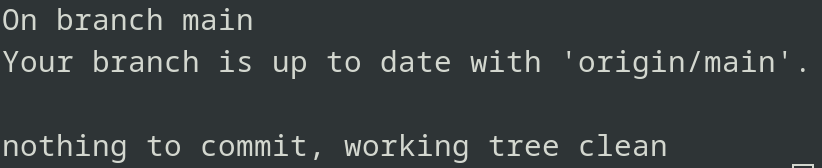
</div>

3. Open the [notebook from the first day](https://github.com/LauzHack/deep-learning-bootcamp/blob/main/day01/Seminar.ipynb) in your cloned directory. Run the first cell, then the 3rd one, then the 2nd one.
4. Run `git diff` in your terminal. You will see that we changed the cell execution count and this is considered as modification

<div>
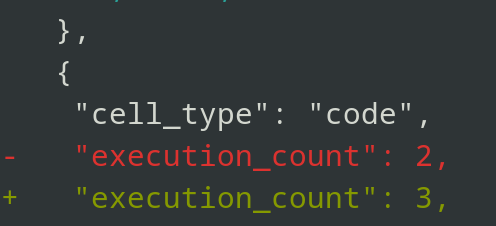
</div>

As we discussed, by using IPython it is easy to abuse the order of cells. Also the cell can be run several times for some author's reasons. Therefore, such modifications can happen often and they litter the **actual important modifications** like actual change of code.

But what if we actually change the code in the IPython notebook? The difference will look like this:

<div>
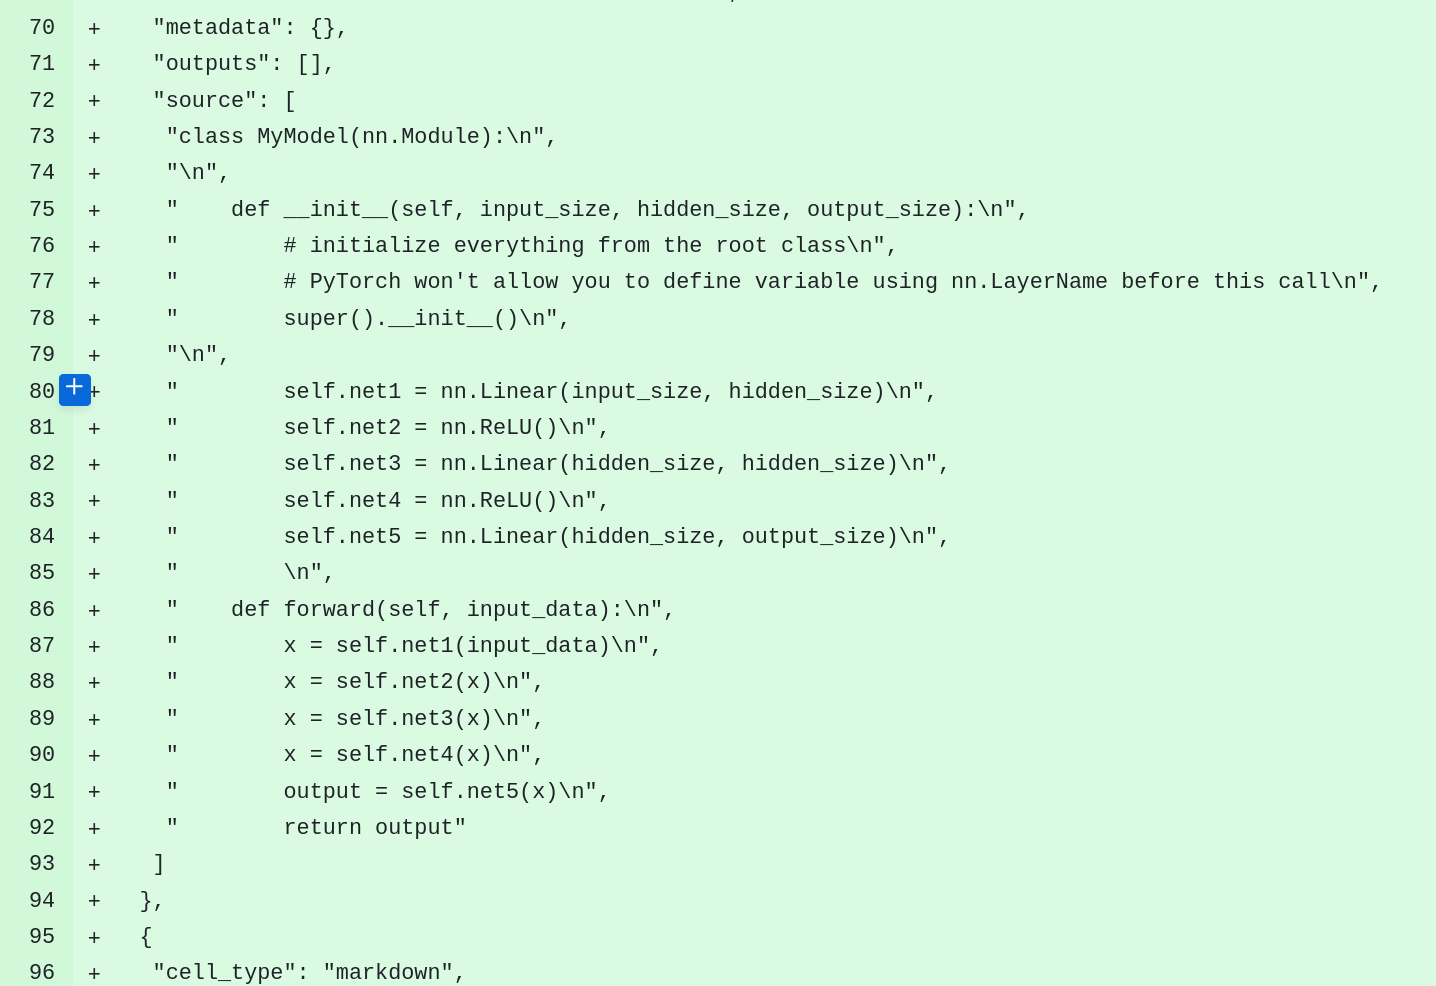
</div>

We can see which lines of code were added and their content. But we also see a lot of IPython stuff, like `outputs` or `metadata`. The change in outputs can look even worse and significantly litter the diff. Here is the result of changing cell output caused by `matplotlib.plt`: 

<div>
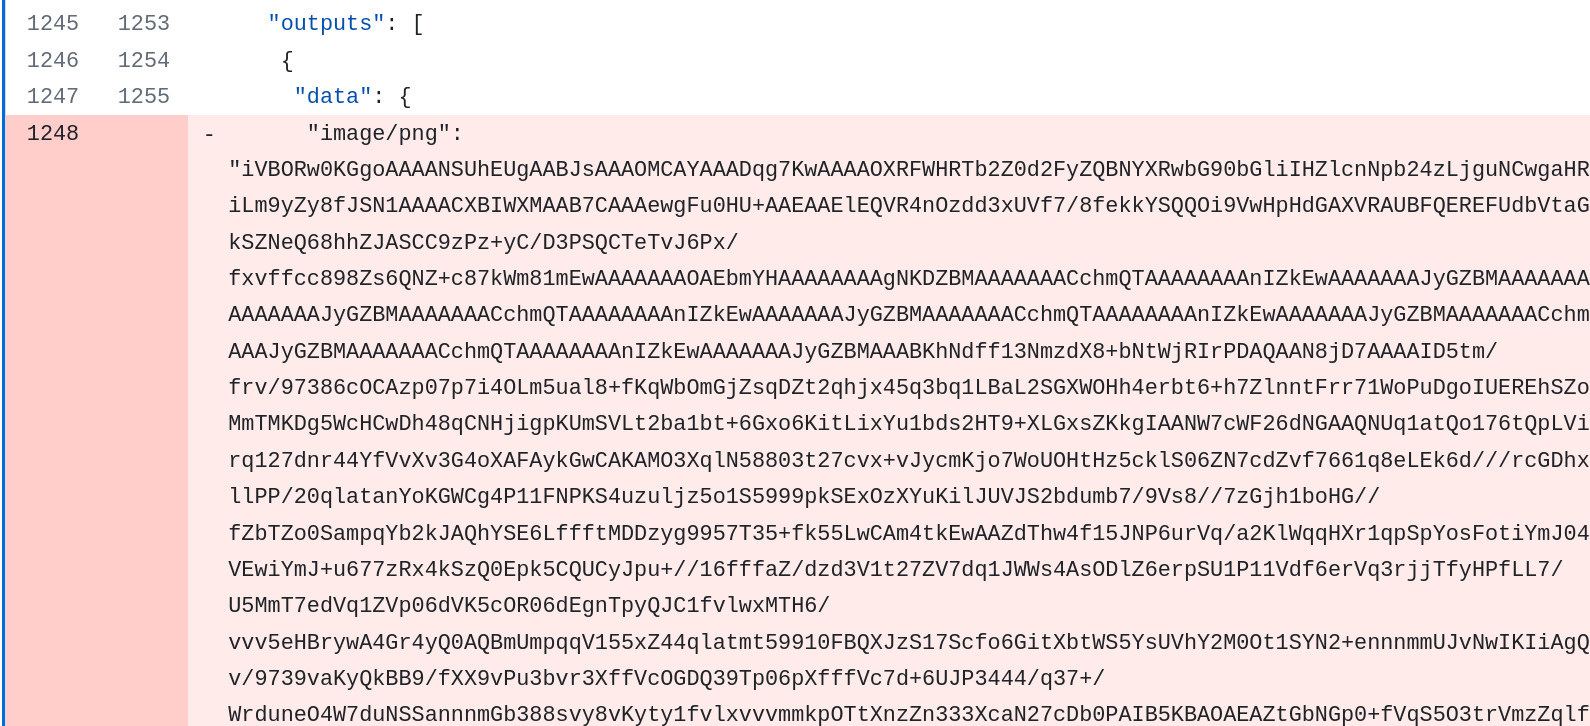
</div>

All of these makes it difficult to merge IPython notebooks from different branches, therefore, making it **hard to work together with your teammates**.

## Solution

To overcome these issues, we should write code in `.py` files instead of IPython. However, writing everything in a single file will make navigation hard. To avoid this, we can use Python packaging support. 

How does it work? We already know how to import packages like PyTorch or Numpy:

```python
from torch import nn # for example
```

We can create our own package and use its objects\functions (they are defined in our package) in the same manner. For example, let's create the following files:

```bash
.
├── src # directory with the core objects\funcs
│   ├── __init__.py # required for Python to know that src is a package
│   └── some_funcs.py # some .py file with definition of some funcs
└── main.py # main script to run the code
```

In [27]:
!mkdir src # create src dir
!touch src/__init__.py # create empty py file

`%%writefile` is cell magic to create files directly in IPython notebook.

In [8]:
%%writefile src/some_funcs.py
def my_square(x): # for example, let's have this func
    return x**2

class MyNumber: # for example, let's have some class definition
    def __init__(self, x):
        self.x = x

Overwriting src/some_funcs.py


In [9]:
%%writefile main.py 

# because src is a package now, we can use it in the same manner as we used torch
from src.some_funcs import my_square, MyNumber

# some example code
x = 10
mynumber = MyNumber(x)
print(mynumber.x)
mynumber.x = my_square(mynumber.x)
print(mynumber.x)

Writing main.py


No we can run `main.py` and all imports will work

In [10]:
!python3 main.py

10
100


So instead of having everything in one large file `main.py` we divided the code into several sub-files, making it easier to navigate.

Note that we can import everything from our notebook if we want to:

In [11]:
from src.some_funcs import my_square

my_square(10)

100

If we do not want to use long path to func\object like `src.some_funcs`, we can write them only in `__init__.py` file. Then in `main.py`, we will be able to import from `src` directly. Let's see an example:

In [13]:
%%writefile src/__init__.py 

# we could use from ... import *
# to import everything
# but it would be a bad code style
from src.some_funcs import my_square, MyNumber

Overwriting src/__init__.py


In [14]:
%%writefile main.py 

# because src is a package now, we can use it in the same manner as we used torch
from src import my_square, MyNumber

# some example code
x = 10
mynumber = MyNumber(x)
print(mynumber.x)
mynumber.x = my_square(mynumber.x)
print(mynumber.x)

Overwriting main.py


In [16]:
!python3 main.py # still works

10
100


It is also possible to create nested packages:

```bash
.
├── src # directory with the core objects\funcs
│   ├── __init__.py # required for Python to know that src is a package
│   ├── some_funcs.py # some .py file with definition of some funcs   
│   └── some_sub_package # directory with some other objects and funcs
│       ├── __init__.py   # required for Python to know that some_sub_package is a package
│       └── more_funcs.py # some .py file with the definition of some funcs
└── main.py # main script to run the code
```

Nested packages can be used in the same manner:

```python
from src.some_sub_package import something # something should be defined in some_sub_package/__init__.py

# or from src.some_sub_package.more_funcs import something if we do not import in __init__.py

result = something(some_input)
print(result)
```

Note that `main.py` is located outside of `src`. If we put it inside, we can get python error:

In [17]:
!mv main.py src/

In [24]:
# !python3 src/main.py - run this
# 2>&1 | tail -2 is just some magic to crop the error output
!python3 src/main.py 2>&1 | tail -2

    from src import my_square, MyNumber
ModuleNotFoundError: No module named 'src'


To fix this, run code in the following way instead:

In [25]:
!python3 -m src.main

10
100


For configuration enhancement and simplification, we can use [Hydra](https://hydra.cc/)

### Deep Learning Case

For deep learning projects, we can do the same thing. To simplify navigation and enhance code structure, we can create a separate sub package for each component: datasets, models, training pipeline, etc.

We provide a cool [template](https://github.com/Blinorot/pytorch_project_template) where structuring is already done for you. All you have to do is to change some parts that are unique for your task: for example, add your model or change loss function. 

Let's look how it is structured:

```bash
.
├── requirements.txt              # the list of packages that have to be installed (via pip or conda)
├── src                           # main code source
│   ├── configs                   # Hydra Configs for experiment configuration
│   │   ├── baseline.yaml         # general config
│   │   ├── dataloader            # subconfig dir to simplify hydra usage and avoid copy-pasting
│   │   ├── datasets
│   │   ├── metrics
│   │   ├── model
│   │   ├── transforms
│   │   └── writer
│   ├── datasets                  # sub-package with all dataset-related definitions
│   │   ├── base_dataset.py       # base class that does general pre-processing (does the same thing for several datasets)
│   │   ├── collate.py            # collate_fn for dataloader
│   │   ├── example.py            # nested class for base class that defines the dataset elements
│   │   └── __init__.py
│   ├── __init__.py
│   ├── logger                    # sub-package with all logging-related stuff, including wandb
│   │   ├── __init__.py
│   │   ├── logger_config.json
│   │   ├── logger.py
│   │   ├── utils.py
│   │   └── wandb.py
│   ├── loss                     # sub-package for loss functions
│   │   ├── example.py
│   │   └── __init__.py
│   ├── metrics                  # sub-package for metrics
│   │   ├── base_metric.py       # base class for metrics
│   │   ├── example.py           # nested class that defines exact metric
│   │   ├── __init__.py
│   │   └── tracker.py           # wrapper around metrics to average metric across batches
│   ├── model                    # sub-package for models
│   │   ├── baseline_model.py    # definition of model
│   │   └── __init__.py
│   ├── trainer                  # sub-package for training\inference pipeline
│   │   ├── base_trainer.py      # base class for training\infrerence and checkpointing
│   │   ├── __init__.py
│   │   └── trainer.py           # definition of batch processing for our task
│   ├── transforms               # sub-package for custom transforms and augmentations
│   │   ├── __init__.py
│   │   ├── normalize.py
│   │   └── scale.py
│   └── utils                    # sub-package for some utils
│       ├── data_utils.py
│       ├── __init__.py
│       ├── init_utils.py
│       └── io_utils.py
└── train.py                     # main script to train the model
```

## Remark

It should be mentioned that ability to run parts of the code is a plus for IPython notebooks. For example, we can look at the sample from the dataset and see how does it look.

```python
# Example from KWS notebook
dataset.index[:2]

# Example from this seminar
example_img, example_label = mnist_train[0]
print(example_img.shape) # C x H x W, 1 channel -- grayscale image
plt.imshow(example_img[0])
plt.title(example_label)
plt.show()
```

However, most of this can be done using project-style structure too. Just create an empty notebook (which is used **only** for validating your code by visualizing some stuff) and do:

```python
# alternative to KWS notebook
from src.datasets import SpeechCommandDataset

dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

dataset.index[:2]
```

We preserve visualizing capabilities but simplify notebook by moving all complicated code (like the dataset class) to a separate file.